# HotS Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
scores_df = pd.read_csv('~/ML_class/hots_project/scores (2).csv')
char_df = pd.read_csv('~/ML_class/hots_project/chars (2).csv')
mapping = pd.read_csv('~/ML_class/hots_project/FattySips 02 SL-85027-05-Mapping - FattySips 02 SL-85027-05-Mapping.csv')
mapping = mapping[1:91]

In [3]:
# Change ID columns to str
scores_df = scores_df.astype({'ReplayID': str, 'PlayerID': str})
char_df = char_df.astype({'replayid': str, 'playerid': str})

# Merge the columns into a key column
scores_df['key'] = scores_df[['ReplayID', 'PlayerID']].agg('-'.join, axis=1)
char_df['key'] = char_df[['replayid', 'playerid']].agg('-'.join, axis=1)

# Drop the old columns
scores_df = scores_df.drop(columns=['ReplayID', 'PlayerID'])
char_df = char_df.drop(columns=['replayid', 'playerid'])

mapping = mapping.drop(columns=['Type', 'PrimaryName'])
mapping = mapping.rename(columns={'identifierid':'characterid', 'NewGroup':'class'})

In [4]:
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Level                   30000 non-null  int64  
 1   Takedowns               30000 non-null  int64  
 2   SoloKills               30000 non-null  int64  
 3   Assists                 30000 non-null  int64  
 4   Deaths                  30000 non-null  int64  
 5   HighestKillStreak       30000 non-null  int64  
 6   HeroDamage              30000 non-null  int64  
 7   SiegeDamage             30000 non-null  int64  
 8   StructureDamage         30000 non-null  int64  
 9   MinionDamage            30000 non-null  int64  
 10  CreepDamage             30000 non-null  int64  
 11  SummonDamage            30000 non-null  int64  
 12  TimeCCdEnemyHeroes      0 non-null      float64
 13  Healing                 7238 non-null   float64
 14  SelfHealing             30000 non-null

In [5]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   replaybuild      76000 non-null  int64 
 1   gamemode         76000 non-null  int64 
 2   mapid            76000 non-null  int64 
 3   replaylength     76000 non-null  object
 4   timestampreplay  76000 non-null  object
 5   isautoselect     76000 non-null  int64 
 6   characterid      76000 non-null  int64 
 7   characterlevel   76000 non-null  int64 
 8   iswinner         76000 non-null  int64 
 9   key              76000 non-null  object
dtypes: int64(7), object(3)
memory usage: 5.8+ MB


In [6]:
# Merge the two dataframes
data_df = scores_df.join(char_df.set_index('key'), on='key')

In [7]:
rename = {'ReplayID': 'match_id', 'PlayerID': 'p_id', 'level': 'final_team_level', 'Takedowns': 'takedowns', 'SoloKills': 'kills', 
          'Assists': 'assists', 'Deaths':'deaths', 'HighestKillStreak':'highest_kill_streak', 'HeroDamage':'player_dmg_dealt', 'SiegeDamage': 'siege_dmg_dealt',
          'StructureDamage': 'structure_dmg_dealt', 'MinionDamage': 'minion_dmg_dealt', 'CreepDamage': 'creep_dmg', 'SummonDamage': 'summon_dmg_dealt', 'TimeCCdEnemyHeroes': 'cc_time',
          'Healing': 'healing', 'SelfHealing': 'self_healing', 'DamageTaken': 'dmg_taken', 'ExperienceContribution': 'exp_gained', 'TownKills': 'town_kill',
          'TimeSpentDead': 'time_dead', 'MercCampCaptures': 'mercenary_camps_captured', 'WatchTowerCaptures': 'watchtower_capture', 'MetaExperience': 'meta_exp'}

data_df = data_df.rename(columns=rename)


In [8]:
"""
Droped columns:
match_id: identifier
p_id: identifier
cc_time: All null values
structure_dmg_dealt: part of siege_dmg
minion_dmg_dealt: part of siege_dmg
summon_dmg_dealt: part of siege_dmg
meta_exp: total exp gained by the team
takedowns: kills and assists combineed
"""

data = data_df.drop(columns=['characterlevel', 'takedowns', 'structure_dmg_dealt', 'minion_dmg_dealt', 'summon_dmg_dealt', 'cc_time', 'meta_exp', 'key', 'replaybuild', 'gamemode', 'timestampreplay', 'isautoselect'])
data['dmg_taken'] = data['dmg_taken'].replace(np.nan, 0)
data['healing'] = data['healing'].replace(np.nan, 0)
data['time_dead'] = pd.to_timedelta(data['time_dead']).dt.total_seconds().astype('float32')
data['replaylength'] = pd.to_timedelta(data['replaylength']).dt.total_seconds().astype('float32')

In [9]:
data.describe()

,Level,kills,assists,deaths,highest_kill_streak,player_dmg_dealt,siege_dmg_dealt,creep_dmg,healing,self_healing,dmg_taken,exp_gained,town_kill,time_dead,mercenary_camps_captured,watchtower_capture,mapid,replaylength,characterid,iswinner
count,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,20.195333,3.14000,9.052233,3.191467,7.841533,42894.236400,66879.398967,16848.534633,14874.271133,12751.077333,51004.013333,10941.849300,1.352633,121.044998,3.098133,1.043833,1009.041333,1155.314697,40.115200,0.500000
std,2.976935,2.75885,5.456870,2.189498,5.252816,24084.869942,46360.632928,16962.555799,32036.694665,14426.260942,29922.217140,5323.852061,1.327281,91.847931,2.605992,2.499424,5.576319,264.462708,26.195575,0.500008
min,7.000000,0.00000,0.000000,0.000000,0.000000,104.000000,727.000000,0.000000,0.000000,0.000000,0.000000,252.000000,0.000000,0.000000,0.000000,0.000000,1001.000000,391.000000,1.000000,0.000000
25%,18.000000,1.00000,5.000000,1.000000,4.000000,25035.750000,32178.000000,5012.000000,0.000000,0.000000,29735.250000,7161.000000,0.000000,50.000000,1.000000,0.000000,1004.000000,969.750000,18.000000,0.000000
50%,20.000000,2.00000,9.000000,3.000000,7.000000,38418.000000,56937.000000,11682.000000,0.000000,8524.000000,43914.500000,10030.500000,1.000000,109.000000,3.000000,0.000000,1008.000000,1126.000000,37.000000,0.500000
75%,22.000000,5.00000,13.000000,5.000000,11.000000,55581.250000,90240.500000,23254.750000,0.000000,20136.500000,65710.250000,13700.500000,2.000000,176.000000,4.000000,1.000000,1013.000000,1307.000000,61.000000,1.000000
max,29.000000,23.00000,35.000000,15.000000,38.000000,226307.000000,482110.000000,194579.000000,324029.000000,145620.000000,278865.000000,57958.000000,13.000000,694.000000,24.000000,28.000000,1022.000000,2451.000000,90.000000,1.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Level                     30000 non-null  int64  
 1   kills                     30000 non-null  int64  
 2   assists                   30000 non-null  int64  
 3   deaths                    30000 non-null  int64  
 4   highest_kill_streak       30000 non-null  int64  
 5   player_dmg_dealt          30000 non-null  int64  
 6   siege_dmg_dealt           30000 non-null  int64  
 7   creep_dmg                 30000 non-null  int64  
 8   healing                   30000 non-null  float64
 9   self_healing              30000 non-null  int64  
 10  dmg_taken                 30000 non-null  float64
 11  exp_gained                30000 non-null  int64  
 12  town_kill                 30000 non-null  int64  
 13  time_dead                 30000 non-null  float32
 14  mercen

In [11]:
data.describe()
data.columns
num = ['Level', 'kills', 'assists', 'deaths', 'highest_kill_streak',
       'player_dmg_dealt', 'siege_dmg_dealt', 'creep_dmg', 'healing',
       'self_healing', 'dmg_taken', 'exp_gained', 'town_kill', 'time_dead',
       'mercenary_camps_captured', 'watchtower_capture', 'replaylength', 
       'iswinner']
cat = ['characterid', 'mapid']

In [12]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [13]:
X = data[num].iloc[:,:-1]
calc_vif(X)
#X.info()

,variables,VIF
0,Level,111.320595
1,kills,4.884786
2,assists,12.431165
3,deaths,21.364909
4,highest_kill_streak,12.875102
5,player_dmg_dealt,11.555563
6,siege_dmg_dealt,16.578327
7,creep_dmg,3.851674
8,healing,2.691616
9,self_healing,5.476878


In [14]:
data_new = data.drop(columns=['Level', 'deaths', 'exp_gained', 'highest_kill_streak'])
data_new['time_played'] = data_new['replaylength'] - data_new['time_dead']
data_new = data_new.drop(columns=['replaylength', 'time_dead'])

num = ['kills', 'assists', 'player_dmg_dealt', 'siege_dmg_dealt', 'creep_dmg', 'healing',
       'self_healing', 'dmg_taken', 'town_kill', 'time_played',
       'mercenary_camps_captured', 'watchtower_capture', 'iswinner']

In [15]:
X = data_new[num].iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,kills,3.839738
1,assists,6.497135
2,player_dmg_dealt,10.236498
3,siege_dmg_dealt,5.837058
4,creep_dmg,3.750763
5,healing,2.545785
6,self_healing,5.104024
7,dmg_taken,12.301574
8,town_kill,2.756763
9,time_played,26.889333


In [16]:
data_new.head()

,kills,assists,player_dmg_dealt,siege_dmg_dealt,creep_dmg,healing,self_healing,dmg_taken,town_kill,mercenary_camps_captured,watchtower_capture,mapid,characterid,iswinner,time_played
0,1,10,59589,139540,995,0.0,3970,23246.0,2,1,2,1013,30,1,993.0
1,1,3,24828,81174,0,0.0,8435,74877.0,0,0,5,1013,13,0,949.0
2,4,13,44062,51925,23919,0.0,27716,70353.0,3,4,2,1013,20,1,1025.0
3,2,2,35140,35495,0,0.0,8040,36937.0,0,0,5,1013,24,0,903.0
4,0,3,13803,19154,0,60990.0,0,35182.0,0,0,1,1013,86,0,864.0


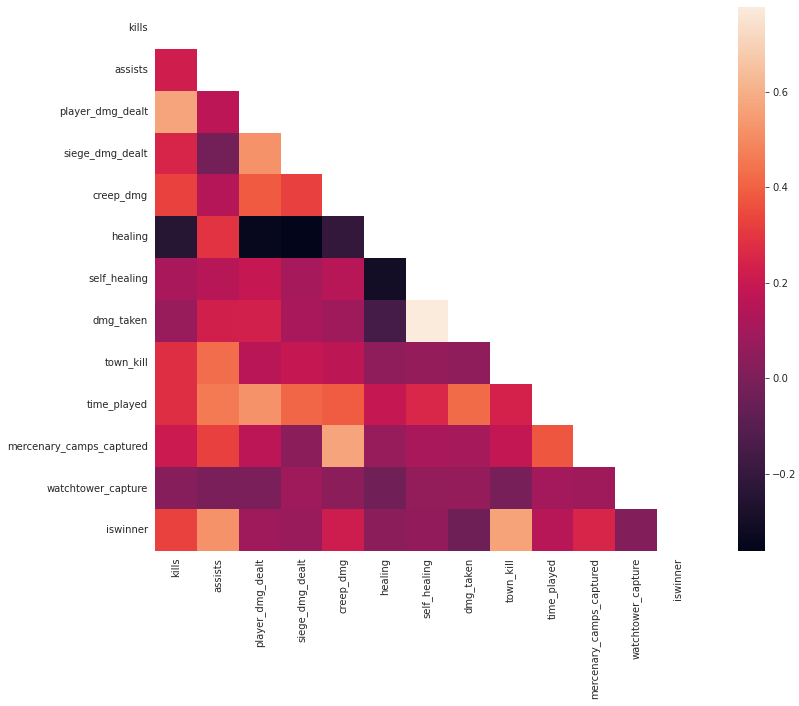

In [17]:
import seaborn as sns
# represent feature correlation matrix using a heatmap
corr = data_new[num].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(corr, mask=mask, square=True)
# plot the heatmap
#sns.heatmap(corr, 
#        xticklabels=corr.columns,
#        yticklabels=corr.columns)

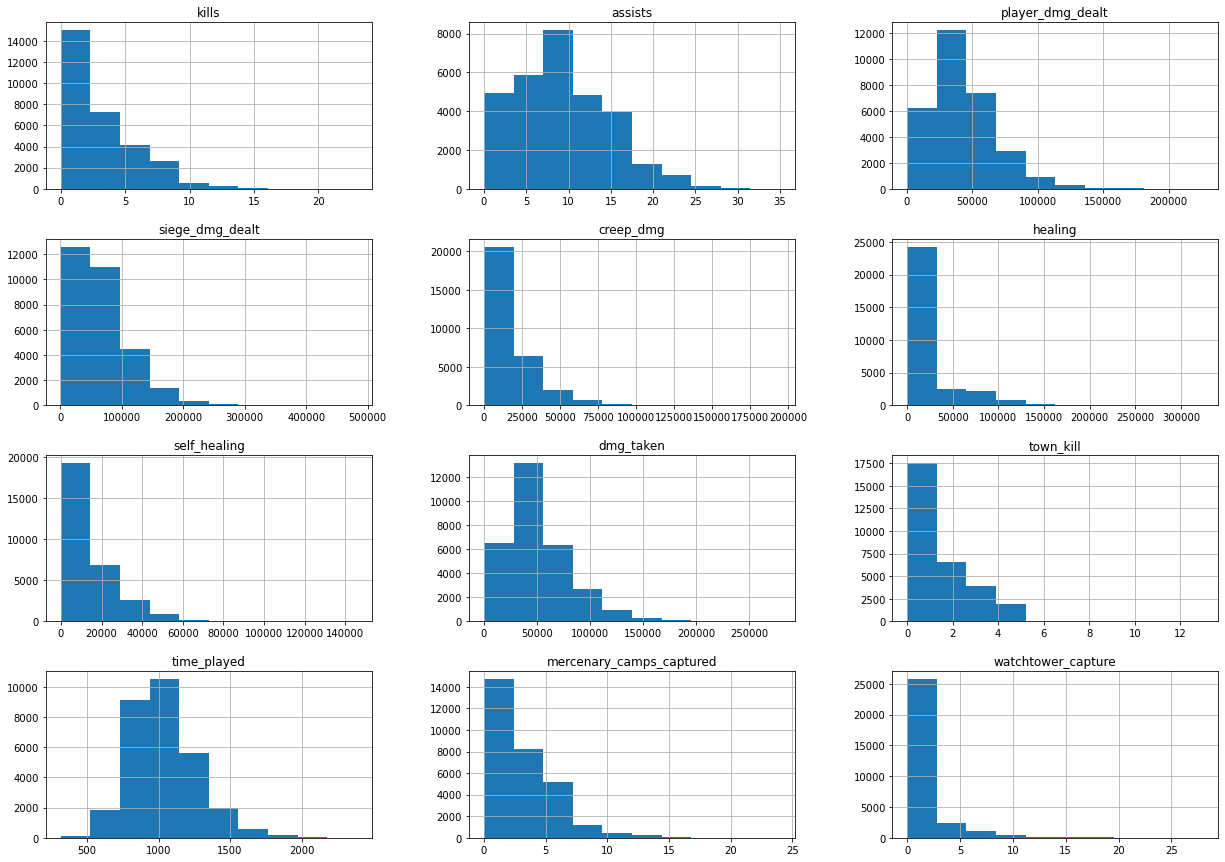

In [18]:
num2 = ['kills', 'assists', 'player_dmg_dealt', 'siege_dmg_dealt', 'creep_dmg', 'healing',
       'self_healing', 'dmg_taken', 'town_kill', 'time_played',
       'mercenary_camps_captured', 'watchtower_capture']
data_new[num2].hist(figsize=(21, 15))
plt.show()

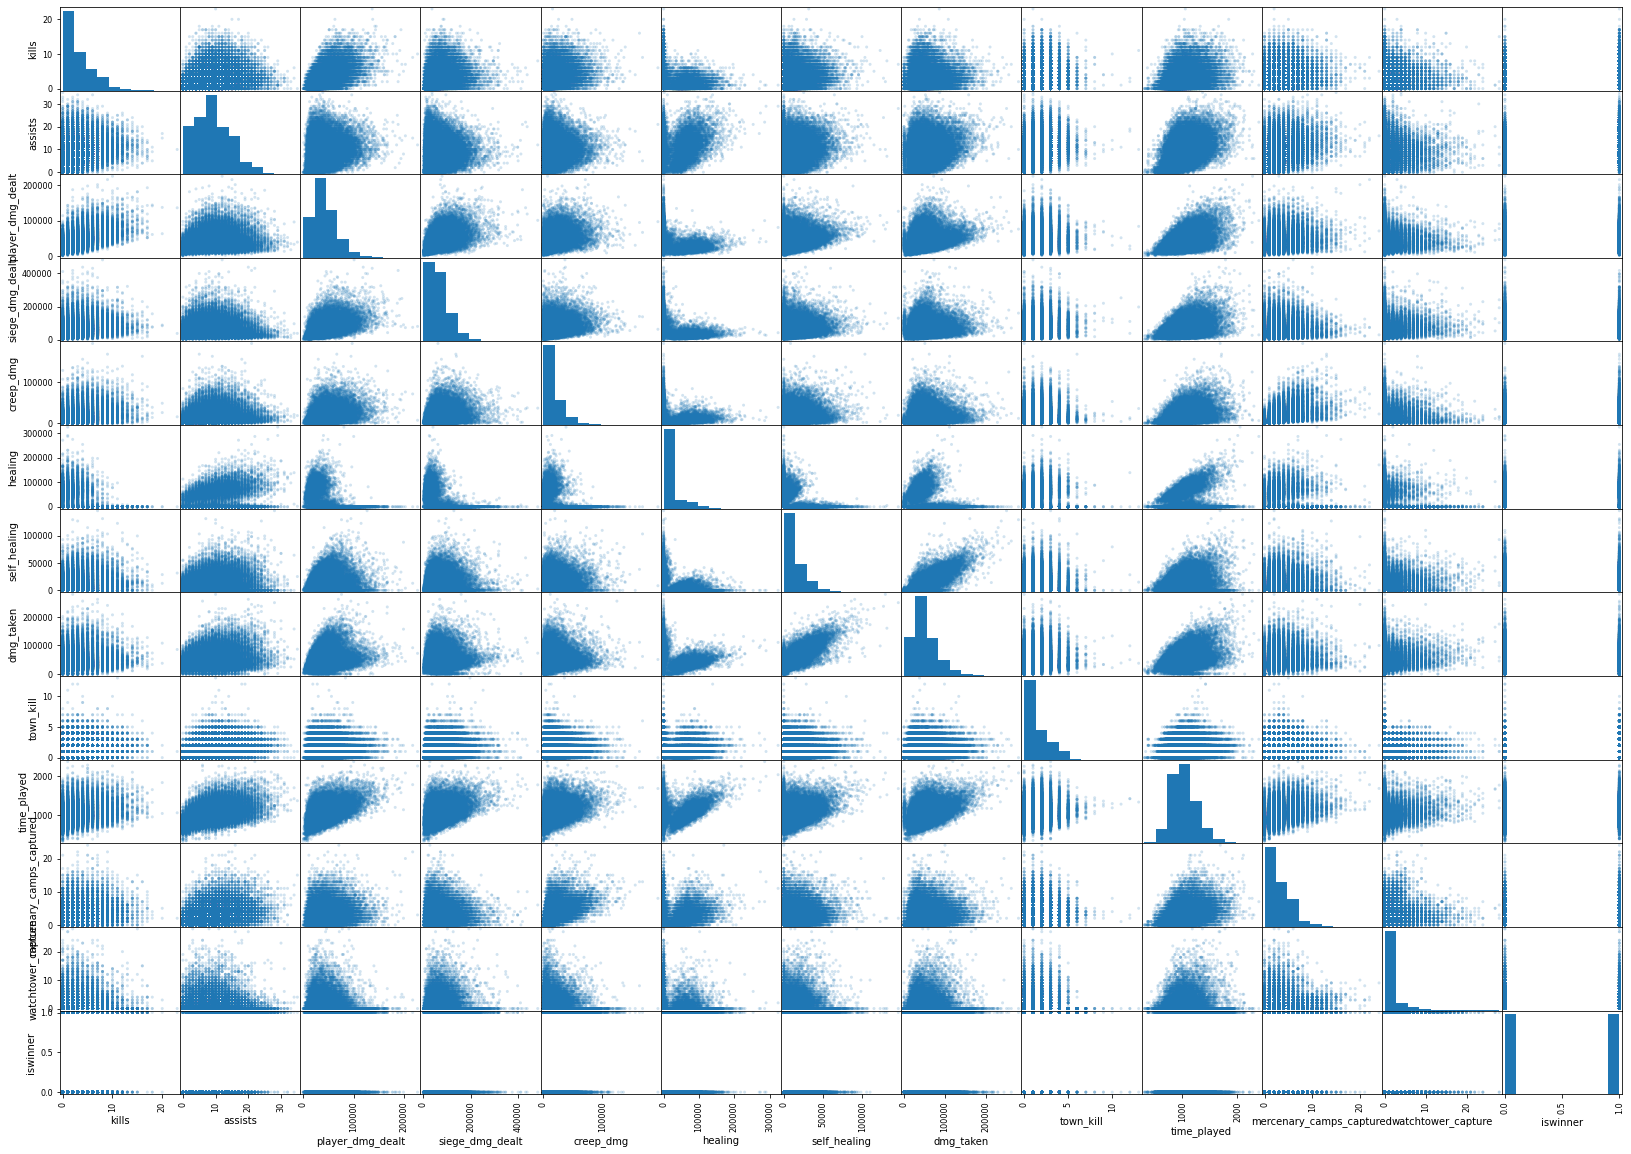

In [19]:
pd.plotting.scatter_matrix(data_new[num], alpha=0.2, figsize=(28, 20))
plt.show()

In [20]:
features = ['kills', 'assists', 'player_dmg_dealt', 'siege_dmg_dealt', 'creep_dmg', 
       'healing', 'self_healing', 'dmg_taken', 'town_kill', 'time_played', 
       'mercenary_camps_captured', 'watchtower_capture', 'mapid', 'characterid']

num = ['kills', 'assists', 'player_dmg_dealt', 'siege_dmg_dealt', 'creep_dmg', 
       'healing', 'self_healing', 'dmg_taken', 'town_kill', 'time_played',
      'mercenary_camps_captured', 'watchtower_capture']

cat = ['mapid', 'characterid']

target = ['iswinner']

In [21]:
from sklearn.preprocessing import StandardScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipe = Pipeline([
    ('scaler', StandardScaler())])
cat_pipe = Pipeline([
    ('binaryencoder', BinaryEncoder(cols=[cat]))])
ct = ColumnTransformer([
    ('num', num_pipe, num),
    ('cat', BinaryEncoder(cols=cat), cat)])

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_new[features], data_new[target], test_size=0.2)
y_train_prep, y_test_prep = y_train.to_numpy(), y_test.to_numpy()

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24000, 14), (24000, 1), (6000, 14), (6000, 1))

In [24]:
from sklearn.decomposition import PCA
X_train_num = num_pipe.fit_transform(X_train[num])
pca = PCA(n_components=12)
pca.fit(X_train_num)
pca.explained_variance_ratio_

array([0.28787003, 0.15016219, 0.13299963, 0.09293486, 0.08251598,
       0.07354034, 0.06189575, 0.03446694, 0.02812006, 0.02512181,
       0.01652904, 0.01384337])

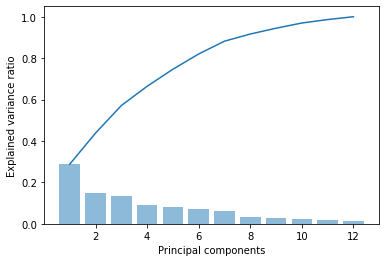

In [25]:
plt.bar(range(1, 13), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.plot(range(1, 13), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [26]:
x_train_prep = ct.fit_transform(X_train)
x_test_prep = ct.transform(X_test)
x_train_prep[:3]

array([[-0.05177723, -0.18674047, -0.7659087 , -0.88817179, -0.87849188,
         0.77279322, -0.62596303, -0.0277748 , -0.2638297 , -1.12935175,
        -1.19005236, -0.41627354,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ],
       [-1.13706407, -1.47060028, -1.14311106, -0.42291191, -0.78121326,
        -0.46465512, -0.18769735, -0.49278063, -1.01700118, -1.85205004,
        -0.80402162, -0.41627354,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ],
       [-0.05177723, -0.7369661 , -0.32243099, -0.41434434, -0.5381642 ,
        -0.46465512, -0.87953548, -1.10642272, -1.01700118, -0.60023337,
        -0.41799087, -0.41627354,  0.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.    

In [27]:
#from sklearn.decomposition import TruncatedSVD

#svd = TruncatedSVD(n_components=100, n_iter=7)
#X_train_reduced = svd.fit_transform(X_train_prep)

#plt.bar(range(1, 101), svd.explained_variance_ratio_, alpha=0.5, align='center')
#plt.step(range(1, 101), np.cumsum(svd.explained_variance_ratio_), where='mid')
#plt.ylabel('Explained variance ratio')
#plt.xlabel('Principal components')
#plt.show()

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

param_grid = [{'max_iter':[100, 300, 500],'C':[0.001, 0.01, 0.1, 1, 10, 100], 
               'solver':['newton-cg', 'liblinear']}]

grid_search = GridSearchCV(lr, param_grid, cv=10, return_train_score=True)
grid_search.fit(x_train_prep, y_train_prep.ravel())
grid_search.best_params_

{'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}

In [29]:
grid_search.best_params_

{'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}

In [30]:
lr_model_ind = LogisticRegression(C=.1, solver='newton-cg')
#svd = TruncatedSVD(n_components=80, n_iter=7)

In [31]:
from sklearn.pipeline import make_pipeline

full_pipe = make_pipeline(ct, 
                         lr_model_ind)

In [32]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10,random_state=None).split(X_train, y_train_prep)

scores = []
for k, (train_index, test_index) in enumerate(kfold):
    xk_train = X_train.iloc[train_index]
    xk_test = X_train.iloc[test_index]
    yk_train, yk_test = y_train_prep[train_index], y_train_prep[test_index]
    full_pipe.fit(xk_train, yk_train.ravel())
       
    score = full_pipe.score(xk_test, yk_test.ravel())
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train_prep[train_index].ravel()), score))
    print('CVaccuracy: %.3f +/-%.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [10814 10786], Acc: 0.838
CVaccuracy: 0.838 +/-0.000
Fold:  2, Class dist.: [10814 10786], Acc: 0.843
CVaccuracy: 0.840 +/-0.003
Fold:  3, Class dist.: [10814 10786], Acc: 0.858
CVaccuracy: 0.846 +/-0.009
Fold:  4, Class dist.: [10814 10786], Acc: 0.845
CVaccuracy: 0.846 +/-0.008
Fold:  5, Class dist.: [10814 10786], Acc: 0.846
CVaccuracy: 0.846 +/-0.007
Fold:  6, Class dist.: [10814 10786], Acc: 0.846
CVaccuracy: 0.846 +/-0.006
Fold:  7, Class dist.: [10815 10785], Acc: 0.848
CVaccuracy: 0.846 +/-0.006
Fold:  8, Class dist.: [10815 10785], Acc: 0.838
CVaccuracy: 0.845 +/-0.006
Fold:  9, Class dist.: [10815 10785], Acc: 0.833
CVaccuracy: 0.844 +/-0.007
Fold: 10, Class dist.: [10815 10785], Acc: 0.838
CVaccuracy: 0.843 +/-0.007


In [33]:
full_pipe.score(X_test, y_test_prep.ravel())

0.8481666666666666

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
x_train_prep.shape, x_test_prep.shape, y_train.shape, y_test.shape

((24000, 23), (6000, 23), (24000, 1), (6000, 1))

In [62]:
import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] 

In [35]:
tf.keras.backend.clear_session()

model = Sequential([
    Dense(60, activation='relu', input_dim=23),
    Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                1440      
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)

In [64]:
model.fit(x_train_prep, y_train_prep, batch_size= 64, epochs=20, validation_split=0.1)

Epoch 1/20
338/338 [==============================] - 6s 14ms/step - loss: 0.2901 - tp: 9585.0000 - fp: 1584.0000 - tn: 9246.0000 - fn: 1185.0000 - accuracy: 0.8718 - precision: 0.8582 - recall: 0.8900 - auc: 0.9477 - prc: 0.9464 - val_loss: 0.3400 - val_tp: 1000.0000 - val_fp: 162.0000 - val_tn: 1024.0000 - val_fn: 214.0000 - val_accuracy: 0.8433 - val_precision: 0.8606 - val_recall: 0.8237 - val_auc: 0.9321 - val_prc: 0.9313
Epoch 2/20
338/338 [==============================] - 4s 11ms/step - loss: 0.2877 - tp: 9568.0000 - fp: 1587.0000 - tn: 9243.0000 - fn: 1202.0000 - accuracy: 0.8709 - precision: 0.8577 - recall: 0.8884 - auc: 0.9484 - prc: 0.9467 - val_loss: 0.3235 - val_tp: 1063.0000 - val_fp: 209.0000 - val_tn: 977.0000 - val_fn: 151.0000 - val_accuracy: 0.8500 - val_precision: 0.8357 - val_recall: 0.8756 - val_auc: 0.9335 - val_prc: 0.9338
Epoch 3/20
338/338 [==============================] - 4s 11ms/step - loss: 0.2881 - tp: 9553.0000 - fp: 1583.0000 - tn: 9247.0000 - fn: 121

In [72]:
model.evaluate(x_test_prep, y_test)

188/188 [==============================] - 2s 9ms/step - loss: 0.3452 - tp: 2565.0000 - fp: 456.0000 - tn: 2528.0000 - fn: 451.0000 - accuracy: 0.8488 - precision: 0.8491 - recall: 0.8505 - auc: 0.9310 - prc: 0.9311


[0.34515276551246643,
 2565.0,
 456.0,
 2528.0,
 451.0,
 0.8488333225250244,
 0.849056601524353,
 0.8504641652107239,
 0.9310188293457031,
 0.9310975074768066]

In [60]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
import keras

x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(data_new[features], data_new[target], test_size=0.15)
y_train_nn, y_test_nn = y_train_nn.to_numpy(), y_test_nn.to_numpy()
# precision-recall curve

def create_model():
    model = Sequential([
        Dense(60, activation='relu', input_dim=23),
        Dense(30, activation='relu'),
        Dense(1, activation='sigmoid')])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
    return model

In [61]:
nn_pipe = Pipeline([('col_trans', ct),
                   ('mlp', KerasClassifier(build_fn=create_model, epochs=5, batch_size=128))])

kfoldnn = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(nn_pipe, x_train_nn, y_train_nn, cv=kfoldnn)
print(results)

C:\Users\corey\AppData\Local\Temp/ipykernel_39608/2044742692.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ('mlp', KerasClassifier(build_fn=create_model, epochs=5, batch_size=128))])


Epoch 1/5
180/180 [==============================] - 3s 9ms/step - loss: 0.4158 - tp: 9809.0000 - fp: 2463.0000 - tn: 9007.0000 - fn: 1671.0000 - accuracy: 0.8199 - precision: 0.7993 - recall: 0.8544 - auc: 0.8962 - prc: 0.8879
Epoch 2/5
180/180 [==============================] - 2s 9ms/step - loss: 0.3400 - tp: 9853.0000 - fp: 1889.0000 - tn: 9581.0000 - fn: 1627.0000 - accuracy: 0.8468 - precision: 0.8391 - recall: 0.8583 - auc: 0.9281 - prc: 0.9230
Epoch 3/5
180/180 [==============================] - 2s 9ms/step - loss: 0.3311 - tp: 9936.0000 - fp: 1902.0000 - tn: 9568.0000 - fn: 1544.0000 - accuracy: 0.8498 - precision: 0.8393 - recall: 0.8655 - auc: 0.9315 - prc: 0.9282
Epoch 4/5
180/180 [==============================] - 2s 9ms/step - loss: 0.3249 - tp: 10013.0000 - fp: 1909.0000 - tn: 9561.0000 - fn: 1467.0000 - accuracy: 0.8529 - precision: 0.8399 - recall: 0.8722 - auc: 0.9338 - prc: 0.9313
Epoch 5/5
20/20 [==============================] - 1s 8ms/step - loss: 0.3516 - tp: 111

In [41]:
x_test_nn_prep = ct.transform(x_test_nn)
model.evaluate(x_test_nn_prep, y_test_nn)

141/141 [==============================] - 0s 3ms/step - loss: 0.2961 - accuracy: 0.8709


[0.2960677146911621, 0.870888888835907]

In [42]:
classes = data_new.merge(mapping, how='left')
classes = classes.drop(columns=['characterid', 'iswinner', 'mapid', 'watchtower_capture'])
classes = classes.sample(n=10000)
feats = ['kills', 'assists', 'player_dmg_dealt', 'siege_dmg_dealt', 
         'creep_dmg', 'healing', 'self_healing', 'dmg_taken', 'town_kill',
         'mercenary_camps_captured', 'time_played']
label = ['class']


In [43]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding, TSNE
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.random_projection import SparseRandomProjection

X_train_classes = num_pipe.fit_transform(classes[feats])
print(type(X_train_classes))
y_train_classes = classes[label].to_numpy()
n_samples, n_features = X_train_num.shape
n_neighbors = 30

<class 'numpy.ndarray'>


In [44]:
X=X_train_classes.copy()
tsne = TSNE(n_components=2, init='pca', perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(X)

C:\Users\corey\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\corey\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [45]:
X=X_train_classes.copy()
lle = LocallyLinearEmbedding(n_neighbors=5, method="standard")
lle_results= lle.fit_transform(X)

In [46]:
tsne_d = {'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1], 'classes':y_train_classes.ravel()}
lle_d = {'lle-2d-one':lle_results[:, 0], 'lle-2d-two':lle_results[:,1], 'classes':y_train_classes.ravel()}

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

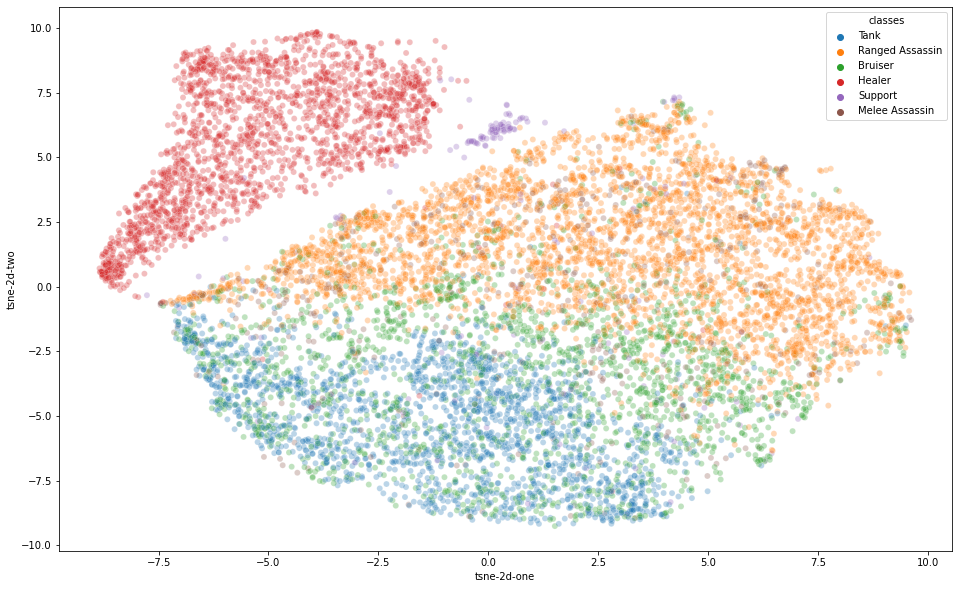

In [47]:
tsne_result = pd.DataFrame(data=tsne_d)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne-2d-one', 
    y='tsne-2d-two',
    hue="classes",
    palette=sns.color_palette("tab10", 6),
    data=tsne_result,
    legend="full",
    alpha=0.3
)

<AxesSubplot:xlabel='lle-2d-one', ylabel='lle-2d-two'>

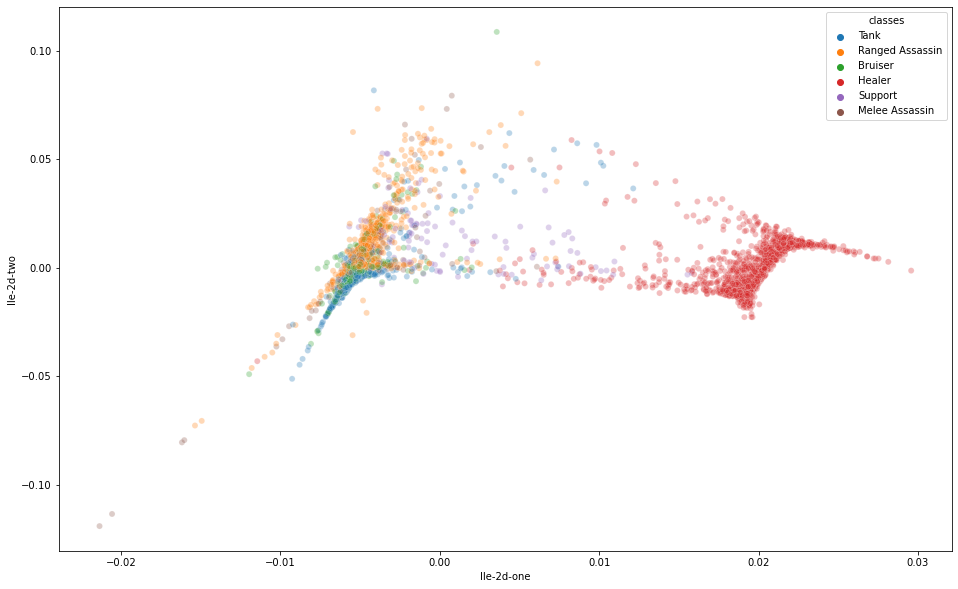

In [48]:
lle_result = pd.DataFrame(data=lle_d)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x='lle-2d-one', 
    y='lle-2d-two',
    hue="classes",
    palette=sns.color_palette("tab10", 6),
    data=lle_result,
    legend="full",
    alpha=0.3
)

In [49]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [50]:
import datetime

In [51]:
ct2 = ColumnTransformer([
    ('cat', BinaryEncoder(cols=cat), cat)])

In [75]:
x_train_nn2, x_test_nn2, y_train_nn2, y_test_nn2 = train_test_split(data_new[features], data_new[target], test_size=0.15)
y_train_nn2, y_test_nn2 = y_train_nn2.to_numpy(), y_test_nn2.to_numpy()

In [73]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import BatchNormalization, Input, Dropout


def create_model2():
    optimizer2 = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss2 = tf.keras.losses.BinaryCrossentropy()
    model = Sequential([
        Input(shape=(23,)),
        BatchNormalization(),
        Dense(30, activation='elu'),
        BatchNormalization(),
        Dense(10, activation='elu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')])
    model.compile(loss=loss2, optimizer=optimizer2, metrics=['accuracy'])
    return model
#model2 = Sequential([
#        Input(shape=(23,)),
#        BatchNormalization(),
#        Dense(60, activation='elu'),
#        BatchNormalization(),
#        Dense(1, activation='sigmoid')
#])

#model2.summary()

In [76]:
nn_pipe2 = Pipeline([('col_trans', ct),
                   ('mlp', KerasClassifier(build_fn=create_model2, epochs=30, batch_size=128))])

kfoldnn2 = StratifiedKFold(n_splits=10, shuffle=True)
results2 = cross_val_score(nn_pipe2, x_train_nn2, y_train_nn2, cv=kfoldnn2)
print(results2)

C:\Users\corey\AppData\Local\Temp/ipykernel_39608/3321146368.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ('mlp', KerasClassifier(build_fn=create_model2, epochs=30, batch_size=128))])


Epoch 1/30
180/180 [==============================] - 2s 9ms/step - loss: 0.4479 - accuracy: 0.7861
Epoch 2/30
180/180 [==============================] - 2s 9ms/step - loss: 0.3560 - accuracy: 0.8440
Epoch 3/30
 83/180 [============>.................] - ETA: 0s - loss: 0.3448 - accuracy: 0.8462

KeyboardInterrupt: 

In [77]:
x_test_nn_prep2 = ct.transform(x_test_nn2)
nn_pipe2.evaluate(x_test_nn_prep2, y_test_nn2)

AttributeError: 'Pipeline' object has no attribute 'evaluate'

In [ ]:
nn_pipe2.layers()

In [78]:
tf.keras.backend.clear_session()

model3 = Sequential([
        Input(shape=(23,)),
        BatchNormalization(),
        Dense(30, activation='elu'),
        Dropout(rate=0.1),
        BatchNormalization(),
        Dense(10, activation='elu'),
        Dropout(rate=0.1),
        BatchNormalization(),
        Dense(1, activation='sigmoid')])

optimizer3 = tf.keras.optimizers.Adam(learning_rate = 0.1)
loss3 = tf.keras.losses.BinaryCrossentropy()
model3.compile(loss=loss3, optimizer=optimizer3, metrics=METRICS)

In [79]:
x_train_nn2_prep = ct.fit_transform(x_train_nn2)

In [80]:
model3.fit(x_train_nn2_prep, y_train_nn2, batch_size= 128, epochs=20, validation_split=0.01)

Epoch 1/20
198/198 [==============================] - 6s 21ms/step - loss: 0.3796 - tp: 13364.0000 - fp: 2968.0000 - tn: 12659.0000 - fn: 2254.0000 - accuracy: 0.8329 - precision: 0.8183 - recall: 0.8557 - auc: 0.9133 - prc: 0.9070 - val_loss: 0.3683 - val_tp: 107.0000 - val_fp: 18.0000 - val_tn: 106.0000 - val_fn: 24.0000 - val_accuracy: 0.8353 - val_precision: 0.8560 - val_recall: 0.8168 - val_auc: 0.9214 - val_prc: 0.9178
Epoch 2/20
198/198 [==============================] - 3s 16ms/step - loss: 0.3629 - tp: 10940.0000 - fp: 2465.0000 - tn: 10178.0000 - fn: 1662.0000 - accuracy: 0.8365 - precision: 0.8161 - recall: 0.8681 - auc: 0.9177 - prc: 0.9106 - val_loss: 0.3807 - val_tp: 106.0000 - val_fp: 15.0000 - val_tn: 109.0000 - val_fn: 25.0000 - val_accuracy: 0.8431 - val_precision: 0.8760 - val_recall: 0.8092 - val_auc: 0.9303 - val_prc: 0.9253
Epoch 3/20
198/198 [==============================] - 3s 14ms/step - loss: 0.3555 - tp: 10836.0000 - fp: 2302.0000 - tn: 10341.0000 - fn: 1766

In [81]:
x_test_nn2_prep = ct.transform(x_test_nn2)

In [82]:
model3.evaluate(x_test_nn2_prep, y_test_nn2)

141/141 [==============================] - 2s 11ms/step - loss: 0.3394 - tp: 2027.0000 - fp: 456.0000 - tn: 1777.0000 - fn: 240.0000 - accuracy: 0.8453 - precision: 0.8164 - recall: 0.8941 - auc: 0.9310 - prc: 0.9266


[0.33942097425460815,
 2027.0,
 456.0,
 1777.0,
 240.0,
 0.8453333377838135,
 0.8163511753082275,
 0.8941332101821899,
 0.9310160875320435,
 0.9266135692596436]

In [71]:
x_train_nn2_prep[:1]

array([[-0.05089903, -0.19279575,  0.24732144,  1.00336526,  0.04581755,
        -0.46057458, -0.7615407 , -0.71891139,  0.49109129, -0.1531936 ,
        -0.03791081,  3.16784545,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ]])